<a href="https://colab.research.google.com/github/arunavaangshuman/PDE/blob/main/10_qubit_SU(16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pip
!pip install cirq
!pip install -q qsimcirq --quiet

In [ ]:
!pip install -q qsimcirq --quiet
!python -m pip install scikit-quant


In [ ]:
import numpy as np
import cirq
import qsimcirq
import skquant.opt as skqopt #optimization routines
from matplotlib import pyplot as plt #plotting tool

In [ ]:
# creating SU(4) to compare with SO(4) and SU(4) includes imaginary terms also
class SU4(cirq.Gate):

    def __init__(self, thetas, inverse=False):
        if (len(thetas)!=15):
            raise ValueError("thetas must be a list of 15 variational parameters")
        self.thetas=thetas
        self.inverse=inverse

    def _num_qubits_(self):
        #We are required to implement this method, 
        #it specifies the number of qubits our gate acts on
        return 2

    def _decompose_(self, q):
        #SU(4) gate object takes two qubits as input
        if (not self.inverse):
          
            yield cirq.rz(self.thetas[0]).on(q[0])
            yield cirq.ry(self.thetas[1]).on(q[0])
            yield cirq.rz(self.thetas[2]).on(q[0])
            yield cirq.rz(self.thetas[3]).on(q[1])
            yield cirq.ry(self.thetas[4]).on(q[1])
            yield cirq.rz(self.thetas[5]).on(q[1])
            yield cirq.CNOT(q[1], q[0])
            yield cirq.rz(self.thetas[6]).on(q[0])
            yield cirq.ry(self.thetas[7]).on(q[1])
            yield cirq.CNOT(q[0], q[1])
            yield cirq.ry(self.thetas[8]).on(q[1]) 
            yield cirq.CNOT(q[1], q[0]) 
            yield cirq.rz(self.thetas[9]).on(q[0])
            yield cirq.ry(self.thetas[10]).on(q[0])
            yield cirq.rz(self.thetas[11]).on(q[0])
            yield cirq.rz(self.thetas[12]).on(q[1])
            yield cirq.ry(self.thetas[13]).on(q[1])
            yield cirq.rz(self.thetas[14]).on(q[1])
            
        else:
            yield cirq.rz(-self.thetas[14]).on(q[1])
            yield cirq.ry(-self.thetas[13]).on(q[1])
            yield cirq.rz(-self.thetas[12]).on(q[1])
            yield cirq.rz(-self.thetas[11]).on(q[0])
            yield cirq.ry(-self.thetas[10]).on(q[0])
            yield cirq.rz(-self.thetas[9]).on(q[0])
            yield cirq.CNOT(q[1], q[0])
            yield cirq.rz(-self.thetas[8]).on(q[1])
            yield cirq.ry(-self.thetas[7]).on(q[1])
            yield cirq.CNOT(q[0], q[1])
            yield cirq.ry(-self.thetas[6]).on(q[0]) 
            yield cirq.CNOT(q[1], q[0]) 
            yield cirq.rz(-self.thetas[5]).on(q[1])
            yield cirq.ry(-self.thetas[4]).on(q[1])
            yield cirq.rz(-self.thetas[3]).on(q[1])
            yield cirq.rz(-self.thetas[2]).on(q[0])
            yield cirq.ry(-self.thetas[1]).on(q[0])
            yield cirq.rz(-self.thetas[0]).on(q[0])
             
    def _unitary_(self):
        #Some other method we need in order to get inverses of U to work
        #as we will need them in our circuits
        return cirq.unitary(cirq.Circuit(self._decompose_(cirq.LineQubit.range(2))))
    


In [ ]:
class Schmidt_decomposition(cirq.Gate):

  def __init__(self, thetas, inverse=False):
        if (len(thetas)!=9):
            raise ValueError("thetas must be a list of 9 variational parameters")
        self.thetas=thetas
        self.inverse=inverse

  def _num_qubits_(self):
        #We are required to implement this method, 
        #it specifies the number of qubits our gate acts on
        return 2

  def _decompose_(self, q):
     
        if (not self.inverse):
          
            yield cirq.rz(self.thetas[0]).on(q[0])
            yield cirq.ry(self.thetas[1]).on(q[0])
            yield cirq.rz(self.thetas[2]).on(q[0])
            yield cirq.CNOT(q[0], q[1])
            yield cirq.rz(self.thetas[3]).on(q[0])
            yield cirq.ry(self.thetas[4]).on(q[0])
            yield cirq.rz(self.thetas[5]).on(q[0])
            yield cirq.rz(self.thetas[6]).on(q[1])
            yield cirq.ry(self.thetas[7]).on(q[1])
            yield cirq.rz(self.thetas[8]).on(q[1])
            
        else:
            yield cirq.rz(-self.thetas[8]).on(q[1])
            yield cirq.ry(-self.thetas[7]).on(q[1])
            yield cirq.rz(-self.thetas[6]).on(q[1])
            yield cirq.rz(-self.thetas[5]).on(q[0])
            yield cirq.ry(-self.thetas[4]).on(q[0])
            yield cirq.rz(-self.thetas[3]).on(q[0])
            yield cirq.CNOT(q[0], q[1])
            yield cirq.rz(-self.thetas[2]).on(q[0])
            yield cirq.ry(-self.thetas[1]).on(q[0])
            yield cirq.rz(-self.thetas[0]).on(q[0])
            

  def _unitary_(self):
        #Some other method we need in order to get inverses of U to work
        #as we will need them in our circuits
        return cirq.unitary(cirq.Circuit(self._decompose_(cirq.LineQubit.range(2))))                 


In [ ]:
class U(cirq.Gate):
    def __init__(self, n, d, l, inverse=False):
        #n := number of qubits
        #d := depth (number of layers)
        #l := list of variational parameters. Must be 15*2*d parameters for SU(4)+ 9 for Schmidt decomposition
        #we specify the variational parameter when we declare a U gate object
        if (len(l)!=(39)):
            raise ValueError("Incorrect number of parameters. l must be of length 39")
        self.n=n
        self.d=d
        self.l=l
        self.inverse=inverse
    
    def _decompose_(self, q):
        #U gate object takes in n qubits as input
        for i in range(self.d):
                for j in range(0, self.n-1, 5):
                    yield Schmidt_decomposition(self.l[9*(self.n-1)*i+9*j:9*(self.n-1)*i+9*j+9]).on(q[j], q[j+1])
              
        for i in range(self.d):
                for j in range(0, self.n-1, 2):
                    yield SU4(self.l[15*(self.n-1)*i+15*j+9:15*(self.n-1)*i+15*j+15+9]).on(q[j], q[j+1])
     
    def _num_qubits_(self):
        #We are required to implement this method, 
        #it specifies the number of qubits our gate acts on
        return self.n   
    
    def _unitary_(self):
        #Some other method we need in order to get inverses of U to work
        #as we will need them in our circuits
        return cirq.unitary(cirq.Circuit(self._decompose_(cirq.LineQubit.range(self.n))))

In [ ]:
class U1(cirq.Gate):
    def __init__(self, n, d, l, inverse=False):
        #n := number of qubits
        #d := depth (number of layers)
        #l := list of variational parameters. Must be 78 parameters
        #we specify the variational parameter when we declare a U gate object
        if (len(l)!=(78)):
            raise ValueError("Incorrect number of parameters. l must be of length 78")
        self.n=n
        self.d=d
        self.l=l
        self.inverse=inverse
    
    def _decompose_(self, q):
        #U gate object takes in n qubits as input
        param=0
        for i in range(self.d):
               
                for j in range(0, self.n-1, 4):
                 
                    yield Schmidt_decomposition(self.l[param:param+9]).on(q[j], q[j+1])
                    param=param+9
                for j in range(0, self.n-1, 2):
                    yield SU4(self.l[param:param+15]).on(q[j], q[j+1])
                    param=param+15
        
    def _num_qubits_(self):
        #We are required to implement this method, 
        #it specifies the number of qubits our gate acts on
        return self.n   
    
    def _unitary_(self):
        #Some other method we need in order to get inverses of U to work
        #as we will need them in our circuits
        return cirq.unitary(cirq.Circuit(self._decompose_(cirq.LineQubit.range(self.n))))

In [ ]:
d=1
n=10

In [ ]:
def checkwave(l,d,n):
    #create circuit object for adding gates to
    circuit = cirq.Circuit()
    #specify number of qubits we want in our circuit
    q = [cirq.GridQubit(0, i) for i in range(n)]
    
    #Add our custom gate class U to our circuit and make sure it acts
    #on all qubits *q
    
    circuit.append(U1(n=8,d=1,l=l[1:79]).on(*q[2:]))
    #circuit.append(U1(n=4,d=1,l=l[40:79]).on(*q[6:10]))
    
    param=79
    #for i in range(4,n):
    #    circuit.append(cirq.rz(l[param]).on(q[i]))
    #    param+=1

   # for i in range(4,10):
   #     circuit.append(SU2(l[param:param+i-(1+count)])).on(q[i])
   #     param+=param+3  
   #     count=count+1  

    for i in range(2,n):
      for j in range(1):
        circuit.append(cirq.rz(l[param+j]).on(q[i]))
        circuit.append(cirq.ry(l[param+j+1]).on(q[i]))
        circuit.append(cirq.rz(l[param+j+2]).on(q[i]))
      param+=3 
    circuit.append(cirq.qft(*q))

    #print(circuit)

    #Create simulator object
    #simulator = cirq.Simulator()
    
    #Direct wavefunction access
    #result = simulator.simulate(circuit).state_vector()
    
    #using qsim simulator
    qsimSim = qsimcirq.QSimSimulator()
    result =          qsimSim.simulate(circuit).state_vector()
    #create final state 
    func = l[0]*np.real(result)
    return func

In [ ]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def element_butterfly(S, loss, profit, strike, sstrike):
    if (strike>=sstrike or profit<=loss):
        raise ValueError("Impossible args")
        
    def outer(S):
        return loss

    def pos(S):
        return loss+(profit-loss)*(S-strike)/(sstrike-strike)
    
    def neg(S):
        return profit - (profit-loss)*(S-sstrike)/(sstrike-strike)
    
    if (S <= strike or S>(2*sstrike-strike)):
        return outer(S)
    
    if ((S>strike) and (S<=sstrike)):
        return pos(S)
    
    if ((S>sstrike) and (S<=(2*sstrike-strike))):
        return neg(S)


'''
Function to generate f(S) where f is the butterfly call option, and S is
a numpy array corresponding to the value of the stock at each point.
loss= minimum option price (usually  negative)
profit= peak option price
strike= strike price (stock price when option's value starts to grow')
sstrike= sell strike price (stock price when option's value reaches peak (profit)')
returns: numpy array
'''
def butterfly(S, loss, profit, strike, sstrike):
    return np.vectorize(element_butterfly, otypes="f")(S, loss, profit, strike, sstrike)

'''
Function to generate f(x), where f is the butterfly call option, and x is
the natural log of stock price S
returns: numpy array
'''
def trans_butterfly(x, loss, profit, strike, sstrike):
    return butterfly(np.exp(x), loss, profit, strike, sstrike)


In [ ]:
x0=np.concatenate(([10*np.random.random()],2*np.pi*np.random.rand(78+24)))
checkwave(x0,d,n)

(0, 0): ───────────────────────────────────────────────────────────────────────────────────qft───
                                                                                           │
(0, 1): ───────────────────────────────────────────────────────────────────────────────────#2────
                                                                                           │
(0, 2): ───<__main__.U1 object at 0x7f850ab487d0>───Rz(0.988π)───Ry(1.89π)────Rz(0.728π)───#3────
           │                                                                               │
(0, 3): ───#2───────────────────────────────────────Rz(0.516π)───Ry(1.5π)─────Rz(1.7π)─────#4────
           │                                                                               │
(0, 4): ───#3───────────────────────────────────────Rz(1.07π)────Ry(0.266π)───Rz(1.95π)────#5────
           │                                                                               │
(0, 5): ───#4────────────────────────────────

array([ 0.00548055,  0.01687936,  0.00234412, ...,  0.06937549,
       -0.00924767, -0.02222939], dtype=float32)

In [ ]:
a=[1,0,12,1]

In [ ]:
a[0:4]

[1, 0, 12, 1]

In [ ]:
def f(l):
    x=np.linspace(0,1,2**n)
    return np.linalg.norm(checkwave(l,d,n)-np.sin(np.pi*x)-np.sin(2*np.pi*x))**2

In [ ]:
def c(l):
    x=np.linspace(0, 2.3, 2**n)
    # f is changeble if want to take gaussian then we can replace trans_butter... by gaussian or sin if sin is needed
    # simply take functions 
    f=trans_butterfly(x, -5, 10, 2, 5)
    return np.linalg.norm(checkwave(l,d,n)-f)**2

In [ ]:
bounds = [[0,280]] #first bound is lambda0, best choice of bounds usually
#depends on number of qubits we are using

#the rest of the bounds are the angle theta in Ry(theta)
for i in range(78+24):
    bounds.append([0,2*np.pi])

In [ ]:
budget = 30000

In [ ]:
x0=np.concatenate(([150*np.random.random()],2*np.pi*np.random.rand(78+24)))
#Optimize using Imfil
result, history = skqopt.minimize(f, x0, bounds, budget, method='imfil')

In [ ]:
x0=np.concatenate(([280*np.random.random()],2*np.pi*np.random.rand(78+24)))

#Optimize using Imfil
result, history = skqopt.minimize(c, x0, bounds, budget, method='imfil')

In [ ]:
clinit=result.optpar

In [ ]:
linit=result.optpar

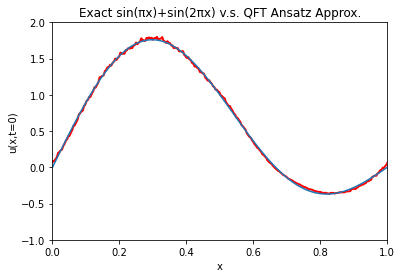

In [ ]:
# using SU2 + d=1, n=10 takes  , bounds=[0,150]
fig = plt.figure()
y=np.linspace(0,1,2**n)
ax = plt.axes(xlim=(0, 1), ylim=(-1, 2))
line, = ax.plot(y, checkwave(linit,d,n), 'r', lw=2)
line2, = ax.plot(y, np.sin(np.pi*y)+np.sin(2*np.pi*y))
plt.xlabel('x')
plt.ylabel('u(x,t=0)')
plt.title('Exact sin(πx)+sin(2πx) v.s. QFT Ansatz Approx.')
plt.savefig('qftplot.png')

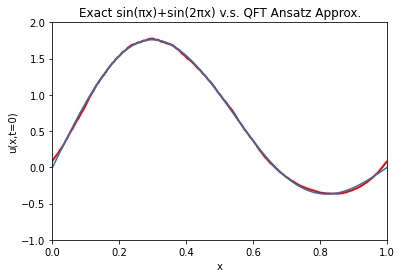

In [ ]:
# using SU2 + d=1, n=10 takes  , bounds=[0,150], using qsim simulator
fig = plt.figure()
y=np.linspace(0,1,2**n)
ax = plt.axes(xlim=(0, 1), ylim=(-1, 2))
line, = ax.plot(y, checkwave(linit,d,n), 'r', lw=2)
line2, = ax.plot(y, np.sin(np.pi*y)+np.sin(2*np.pi*y))
plt.xlabel('x')
plt.ylabel('u(x,t=0)')
plt.title('Exact sin(πx)+sin(2πx) v.s. QFT Ansatz Approx.')
plt.savefig('qftplot.png')

In [ ]:
f(linit)

0.3867844469418731

In [ ]:
c(clinit)

124.67760482001177

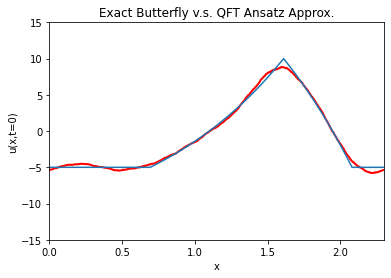

In [ ]:
fig = plt.figure()
y=np.linspace(0, 2.3, 2**n)
ax = plt.axes(xlim=(0, 2.3),ylim=(-15, 15))
line, = ax.plot(y, checkwave(clinit,d,n), 'r', lw=2)
line2, = ax.plot(y,trans_butterfly(y, -5, 10, 2, 5))
plt.xlabel('x')
plt.ylabel('u(x,t=0)')
plt.title('Exact Butterfly v.s. QFT Ansatz Approx.')
plt.savefig('qftplot.png')